## Diagnostic

In [22]:
# execute this cell when you want to free up the memory!
import gc
gc.collect()

85

#

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from modules import Annotations, Samples, Sequencing
import glob

# Seaborn
import seaborn as sns

# Deseq
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats

# skLearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.discriminant_analysis import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split

## Step 1: Data Preprocessing

In [4]:
samples = Samples.Samples()
samples.load_data(glob.glob('data/*.txt'))

annotations = Annotations.Annotations()
annotations.load_annotations("data/GSE124439_family.xml")

sequencing = Sequencing.Sequencing(samples=samples, annotations=annotations)

Annotations loaded. Action accomplished with %d errors inside %d files.


In [5]:
# Printing both samples and genes count grouped by sample.
pd.merge(left=annotations.get_annotations(), right=samples.get_samples(), left_index=True, right_index=True)

,cns subregion,sample group,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,...,X6B_LINE:CR1:LINE,X7A_LINE:CR1:LINE,X7B_LINE:CR1:LINE,X7C_LINE:CR1:LINE,X7D_LINE:CR1:LINE,X8_LINE:CR1:LINE,X9_LINE:L1:LINE,Zaphod2:hAT-Tip100:DNA,Zaphod3:hAT-Tip100:DNA,Zaphod:hAT-Tip100:DNA
GSM3533230,Frontal Cortex,ALS Spectrum MND,42,149,0,3327,101,78,4,0,...,986,2218,2096,1120,84,556,134,570,2045,2446
GSM3533231,Frontal Cortex,ALS Spectrum MND,25,107,2,1787,153,109,2,1,...,1216,2373,2001,1144,118,582,153,552,2057,2279
GSM3533232,Frontal Cortex,ALS Spectrum MND,20,95,0,1830,121,127,1,1,...,905,2018,1815,1011,84,571,126,479,1659,1778
GSM3533233,Frontal Cortex,ALS Spectrum MND,22,101,0,2131,142,143,5,1,...,935,2278,2032,1198,97,562,132,540,2032,2135
GSM3533234,Frontal Cortex,ALS Spectrum MND,22,102,0,1706,83,178,1,3,...,966,2295,1993,1152,96,582,124,539,1742,1939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM3533401,Frontal Cortex,ALS Spectrum MND,23,113,0,2130,72,71,2,3,...,553,1243,1089,658,72,320,73,311,1102,1169
GSM3533402,Frontal Cortex,ALS Spectrum MND,134,300,0,6077,171,42,8,5,...,719,1988,1691,966,119,460,109,399,1619,1724
GSM3533403,Frontal Cortex,ALS Spectrum MND,64,290,0,4752,118,174,8,2,...,623,1466,1246,726,61,358,107,347,1284,1469
GSM3533404,Frontal Cortex,ALS Spectrum MND,124,332,0,3516,141,173,3,2,...,743,1846,1680,936,110,479,120,503,1646,1839


## Step 2: Descriptive Analysis

### Sample Description

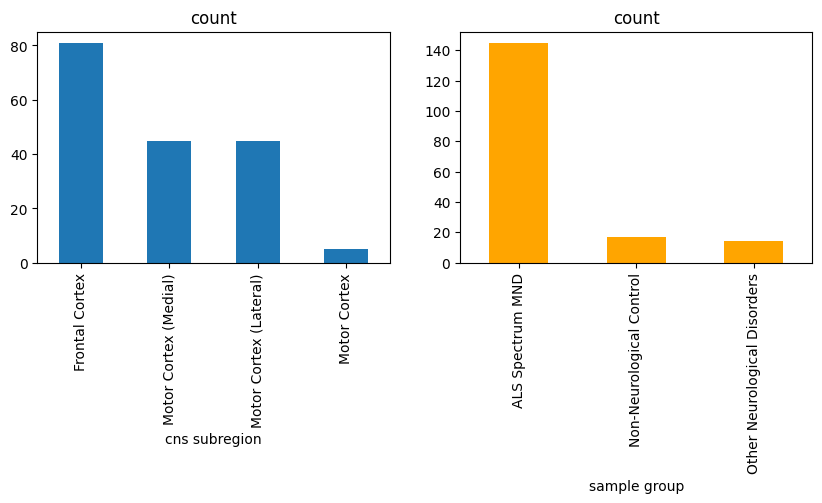

In [4]:
fig, (ax0, ax1) = plt.subplots(nrows=1,ncols=2, figsize=(10,3))

sample_source = annotations.get_annotations_column("cns subregion").value_counts().plot.bar(ax=ax0, subplots=True)
disease_group = annotations.get_annotations_column("sample group").value_counts().plot.bar(ax=ax1, subplots=True, color="orange")

<Axes: title={'center': 'Standard Deviation'}, ylabel='Frequency'>

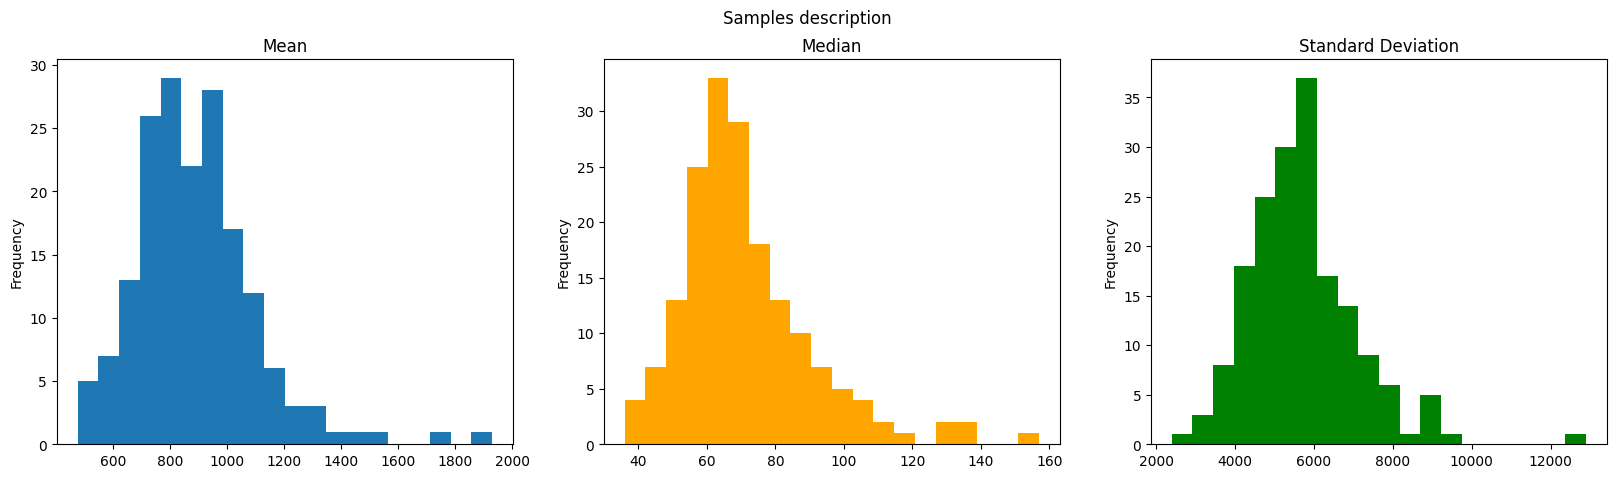

In [5]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1,ncols=3, figsize=(20,5))

fig.suptitle("Samples description")

ax0.set_title("Mean")
samples.get_samples().mean(axis=1).plot.hist(ax=ax0, bins=20)

ax1.set_title("Median")
samples.get_samples().median(axis=1).plot.hist(ax=ax1, bins=20, color="orange")

ax2.set_title("Standard Deviation")
samples.get_samples().std(axis=1).plot.hist(ax=ax2, bins=20, color="green")

### RNA Count Description

<Axes: title={'center': 'Standard Deviation'}, ylabel='Frequency'>

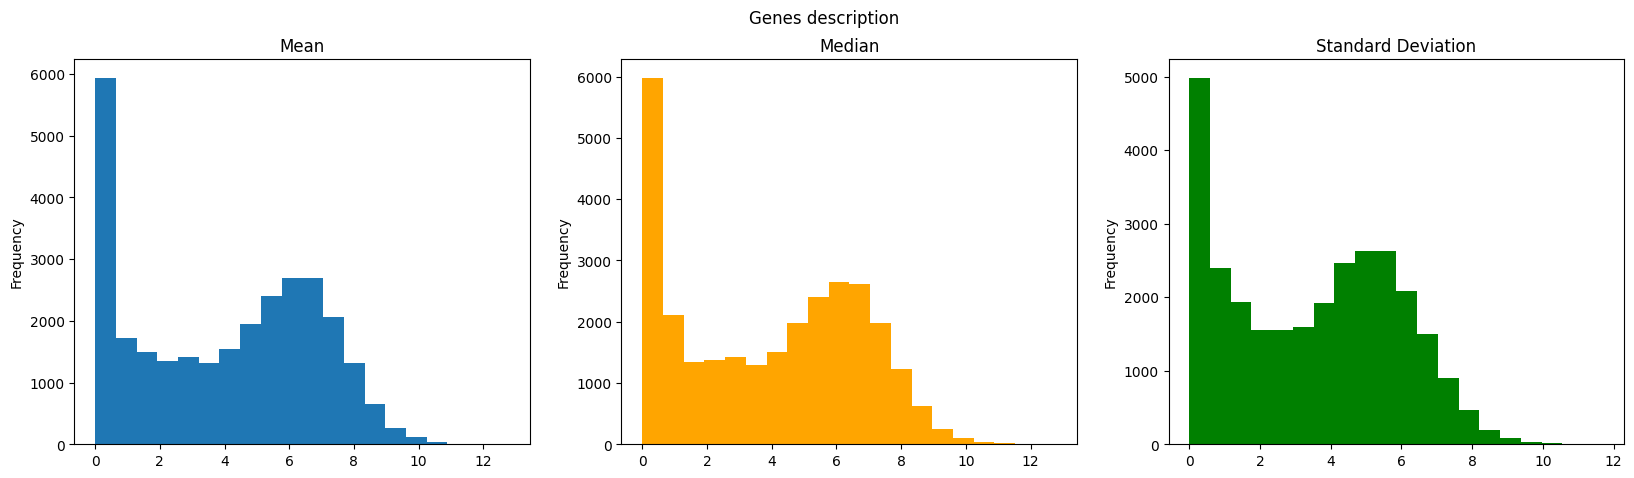

In [35]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1,ncols=3, figsize=(20,5))

fig.suptitle("Genes description")

ax0.set_title("Mean")
Samples.Samples.log_transform_df(samples.get_samples().mean(axis=0)).plot.hist(ax=ax0, bins=20)

ax1.set_title("Median")
Samples.Samples.log_transform_df(samples.get_samples().median(axis=0)).plot.hist(ax=ax1, bins=20, color="orange")

ax2.set_title("Standard Deviation")
Samples.Samples.log_transform_df(samples.get_samples().std(axis=0)).plot.hist(ax=ax2, bins=20, color="green")

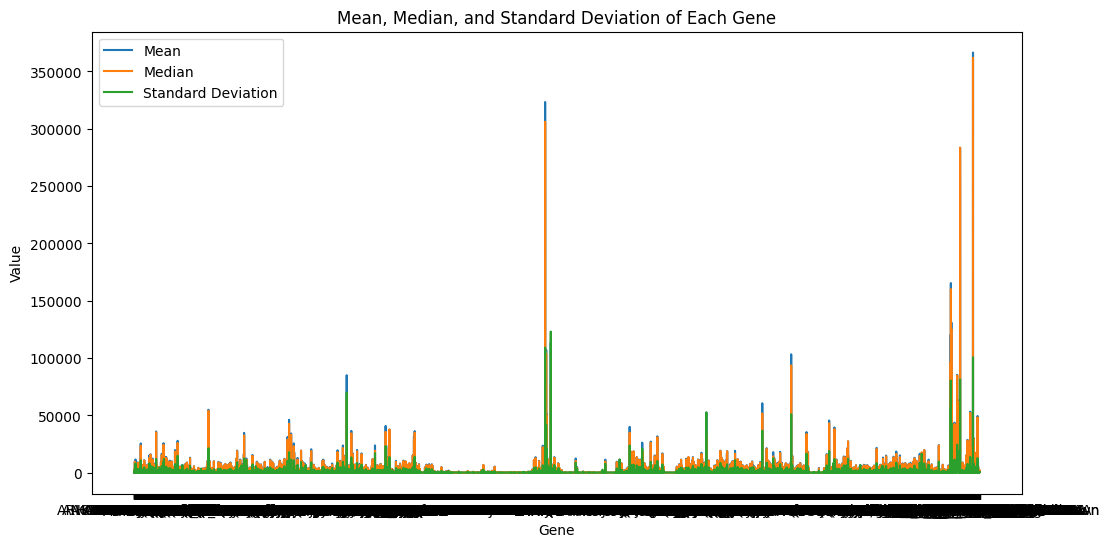

In [32]:
def get_mean_median_std() -> None:
    plt.figure(figsize=(12, 6))

    plt.plot(samples.get_samples().mean(), label='Mean')
    plt.plot(samples.get_samples().median(), label='Median')
    plt.plot(samples.get_samples().std(), label='Standard Deviation')

    plt.legend(loc='best')
    plt.title('Mean, Median, and Standard Deviation of Each Gene')
    plt.xlabel('Gene')
    plt.ylabel('Value')

    plt.show()
    return

get_mean_median_std()

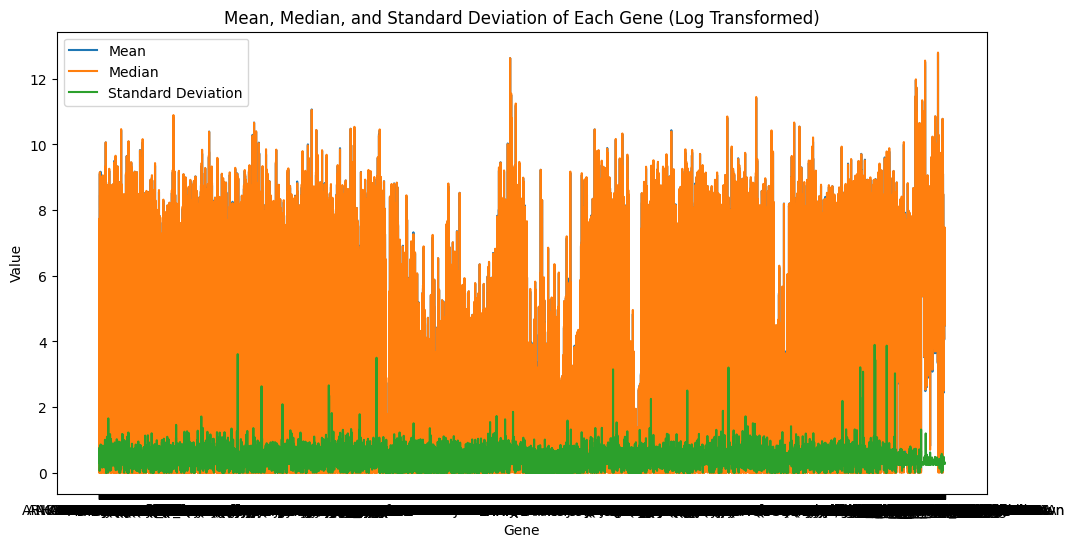

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,X6B_LINE:CR1:LINE,X7A_LINE:CR1:LINE,X7B_LINE:CR1:LINE,X7C_LINE:CR1:LINE,X7D_LINE:CR1:LINE,X8_LINE:CR1:LINE,X9_LINE:L1:LINE,Zaphod2:hAT-Tip100:DNA,Zaphod3:hAT-Tip100:DNA,Zaphod:hAT-Tip100:DNA
GSM3533382,3.761200,5.247024,0.0,8.307213,4.532599,5.308268,0.693147,2.197225,4.343805,0.693147,...,6.931472,7.768110,7.667626,7.143618,4.615121,6.410175,4.948760,6.313548,7.727535,7.711549
GSM3533252,3.637586,4.709530,0.0,8.446985,4.634729,4.174387,2.079442,0.693147,4.234107,0.000000,...,6.781058,7.639161,7.554335,6.978214,4.787492,6.171701,4.867534,6.265301,7.507690,7.561122
GSM3533337,3.465736,4.709530,0.0,7.303170,4.442651,4.110874,0.693147,0.693147,2.564949,0.000000,...,6.487684,7.213768,7.204893,6.620073,4.127134,5.834811,4.634729,5.849325,7.023759,7.271009
GSM3533314,2.708050,3.737670,0.0,7.689829,4.663439,5.293305,1.609438,0.000000,3.218876,0.000000,...,6.865891,7.609862,7.505492,6.992096,4.605170,6.269096,4.983607,6.102559,7.328437,7.471932
GSM3533391,3.637586,4.779123,0.0,7.127694,4.653960,5.129899,0.693147,0.693147,3.091042,0.693147,...,6.742881,7.508239,7.393878,6.806829,4.574711,6.159095,4.795791,6.030685,7.350516,7.478170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM3533291,3.401197,4.962845,0.0,7.265430,4.634729,4.753590,1.098612,1.609438,2.708050,0.693147,...,6.510258,7.331060,7.185387,6.601230,4.454347,5.978886,4.532599,5.802118,7.154615,7.250636
GSM3533349,3.465736,4.962845,0.0,7.331060,4.691348,4.812184,1.098612,0.693147,4.941642,0.000000,...,6.632002,7.452982,7.362645,6.765039,4.343805,6.059123,4.812184,6.066108,7.299121,7.415175
GSM3533339,3.688879,4.564348,0.0,7.109879,4.317488,4.499810,0.693147,1.386294,3.688879,0.000000,...,6.533789,7.261927,7.201171,6.542472,4.624973,5.872118,4.430817,5.707110,7.044033,7.237778
GSM3533399,3.850148,5.192957,0.0,7.972466,4.499810,4.700480,0.693147,1.945910,3.850148,0.693147,...,6.680855,7.435438,7.305860,6.768493,4.499810,6.152733,4.605170,6.093570,7.429521,7.515889


In [30]:
def log_transformation(df) -> pd.DataFrame:
    log_genes_counts = np.log1p(df)

    mean = log_genes_counts.mean()
    median = log_genes_counts.median()
    std_dev = log_genes_counts.std()

    plt.figure(figsize=(12, 6))

    plt.plot(mean, label='Mean')
    plt.plot(median, label='Median')
    plt.plot(std_dev, label='Standard Deviation')

    plt.legend(loc='best')
    plt.title('Mean, Median, and Standard Deviation of Each Gene (Log Transformed)')
    plt.xlabel('Gene')
    plt.ylabel('Value')

    plt.show()
    return

log_transformation(samples.get_samples())

## Step 3: PCA

In [7]:
samples.reduce_to_2d_per_gene()

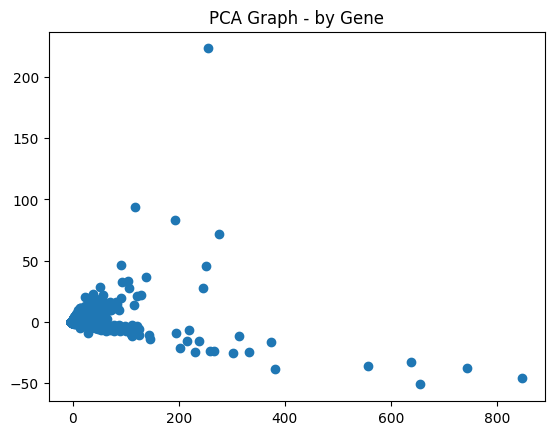

In [8]:
reduced_genes = samples.get_reduced_genes()

plt.scatter(reduced_genes.PC1, reduced_genes.PC2)
plt.title('PCA Graph - by Gene')

plt.show()

## Step 4: tSNE

In [3]:
samples.reduce_to_2d_per_gene_tSNE(3)
samples.reduce_to_2d_per_gene_tSNE(50)
samples.reduce_to_2d_per_gene_tSNE(100)

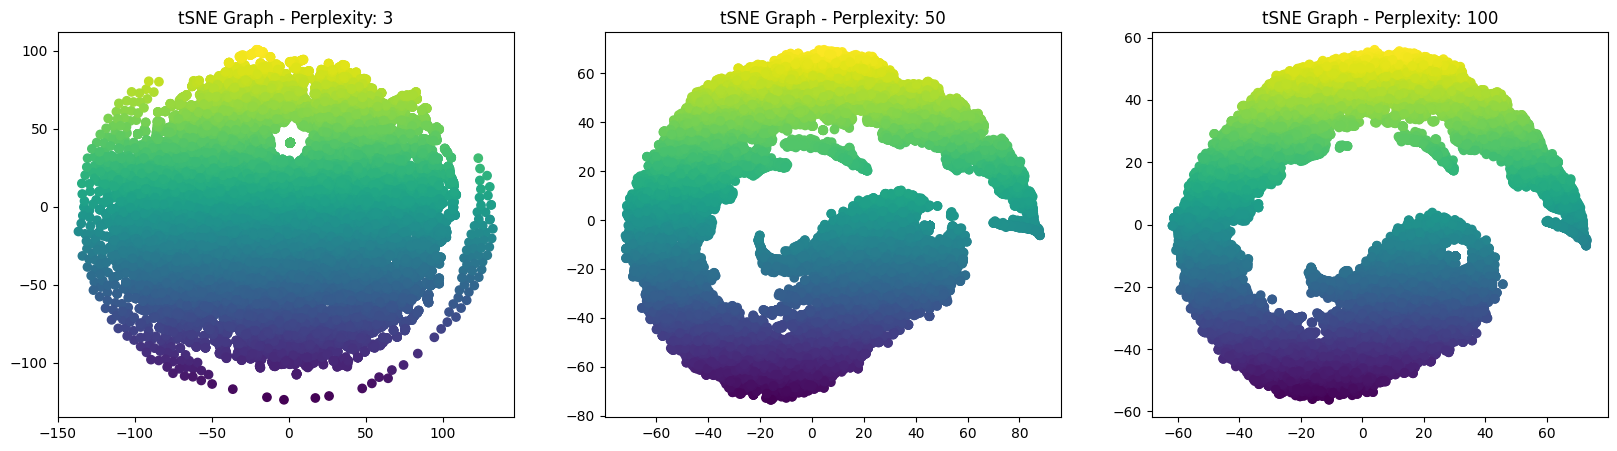

In [5]:
fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(20,5))

reduced_genes = samples.get_reduced_genes_tSNE()

for index, (tSNE_gene_reduced, perplexity) in enumerate(reduced_genes):
    axes[index].scatter(tSNE_gene_reduced[0], tSNE_gene_reduced[1], c=tSNE_gene_reduced[1])
    axes[index].set_title(f"tSNE Graph - Perplexity: {perplexity}")

plt.show()

## Step 5: Univariate Analysis

In [6]:
annotations.get_annotations()['sample group'].value_counts()

sample group
ALS Spectrum MND                145
Non-Neurological Control         17
Other Neurological Disorders     14
Name: count, dtype: int64

In [7]:
als_patients = annotations.get_annotations()[annotations.get_annotations()["sample group"] == "ALS Spectrum MND"]
als_patients

,cns subregion,sample group
GSM3533230,Frontal Cortex,ALS Spectrum MND
GSM3533231,Frontal Cortex,ALS Spectrum MND
GSM3533232,Frontal Cortex,ALS Spectrum MND
GSM3533233,Frontal Cortex,ALS Spectrum MND
GSM3533234,Frontal Cortex,ALS Spectrum MND
...,...,...
GSM3533401,Frontal Cortex,ALS Spectrum MND
GSM3533402,Frontal Cortex,ALS Spectrum MND
GSM3533403,Frontal Cortex,ALS Spectrum MND
GSM3533404,Frontal Cortex,ALS Spectrum MND


In [8]:
healthy = annotations.get_annotations()[annotations.get_annotations()["sample group"] == "Non-Neurological Control"]
healthy

,cns subregion,sample group
GSM3533238,Frontal Cortex,Non-Neurological Control
GSM3533251,Motor Cortex (Medial),Non-Neurological Control
GSM3533259,Motor Cortex (Lateral),Non-Neurological Control
GSM3533266,Frontal Cortex,Non-Neurological Control
GSM3533272,Motor Cortex (Medial),Non-Neurological Control
GSM3533277,Motor Cortex (Lateral),Non-Neurological Control
GSM3533282,Frontal Cortex,Non-Neurological Control
GSM3533290,Motor Cortex (Medial),Non-Neurological Control
GSM3533366,Motor Cortex (Medial),Non-Neurological Control
GSM3533367,Motor Cortex (Lateral),Non-Neurological Control


In [ ]:
diagnosed = annotations.get_annotations()[annotations.get_annotations()["sample group"] != "Non-Neurological Control"]
diagnosed

In [10]:
diagnosed = diagnosed.merge(samples.get_samples(), left_index=True, right_index=True)
diagnosed 

,cns subregion,sample group,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,...,X6B_LINE:CR1:LINE,X7A_LINE:CR1:LINE,X7B_LINE:CR1:LINE,X7C_LINE:CR1:LINE,X7D_LINE:CR1:LINE,X8_LINE:CR1:LINE,X9_LINE:L1:LINE,Zaphod2:hAT-Tip100:DNA,Zaphod3:hAT-Tip100:DNA,Zaphod:hAT-Tip100:DNA
GSM3533230,Frontal Cortex,ALS Spectrum MND,42,149,0,3327,101,78,4,0,...,986,2218,2096,1120,84,556,134,570,2045,2446
GSM3533231,Frontal Cortex,ALS Spectrum MND,25,107,2,1787,153,109,2,1,...,1216,2373,2001,1144,118,582,153,552,2057,2279
GSM3533232,Frontal Cortex,ALS Spectrum MND,20,95,0,1830,121,127,1,1,...,905,2018,1815,1011,84,571,126,479,1659,1778
GSM3533233,Frontal Cortex,ALS Spectrum MND,22,101,0,2131,142,143,5,1,...,935,2278,2032,1198,97,562,132,540,2032,2135
GSM3533234,Frontal Cortex,ALS Spectrum MND,22,102,0,1706,83,178,1,3,...,966,2295,1993,1152,96,582,124,539,1742,1939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM3533401,Frontal Cortex,ALS Spectrum MND,23,113,0,2130,72,71,2,3,...,553,1243,1089,658,72,320,73,311,1102,1169
GSM3533402,Frontal Cortex,ALS Spectrum MND,134,300,0,6077,171,42,8,5,...,719,1988,1691,966,119,460,109,399,1619,1724
GSM3533403,Frontal Cortex,ALS Spectrum MND,64,290,0,4752,118,174,8,2,...,623,1466,1246,726,61,358,107,347,1284,1469
GSM3533404,Frontal Cortex,ALS Spectrum MND,124,332,0,3516,141,173,3,2,...,743,1846,1680,936,110,479,120,503,1646,1839


In [11]:
als_patients = als_patients.merge(samples.get_samples(), left_index=True, right_index=True)
als_patients 

,cns subregion,sample group,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,...,X6B_LINE:CR1:LINE,X7A_LINE:CR1:LINE,X7B_LINE:CR1:LINE,X7C_LINE:CR1:LINE,X7D_LINE:CR1:LINE,X8_LINE:CR1:LINE,X9_LINE:L1:LINE,Zaphod2:hAT-Tip100:DNA,Zaphod3:hAT-Tip100:DNA,Zaphod:hAT-Tip100:DNA
GSM3533230,Frontal Cortex,ALS Spectrum MND,42,149,0,3327,101,78,4,0,...,986,2218,2096,1120,84,556,134,570,2045,2446
GSM3533231,Frontal Cortex,ALS Spectrum MND,25,107,2,1787,153,109,2,1,...,1216,2373,2001,1144,118,582,153,552,2057,2279
GSM3533232,Frontal Cortex,ALS Spectrum MND,20,95,0,1830,121,127,1,1,...,905,2018,1815,1011,84,571,126,479,1659,1778
GSM3533233,Frontal Cortex,ALS Spectrum MND,22,101,0,2131,142,143,5,1,...,935,2278,2032,1198,97,562,132,540,2032,2135
GSM3533234,Frontal Cortex,ALS Spectrum MND,22,102,0,1706,83,178,1,3,...,966,2295,1993,1152,96,582,124,539,1742,1939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM3533401,Frontal Cortex,ALS Spectrum MND,23,113,0,2130,72,71,2,3,...,553,1243,1089,658,72,320,73,311,1102,1169
GSM3533402,Frontal Cortex,ALS Spectrum MND,134,300,0,6077,171,42,8,5,...,719,1988,1691,966,119,460,109,399,1619,1724
GSM3533403,Frontal Cortex,ALS Spectrum MND,64,290,0,4752,118,174,8,2,...,623,1466,1246,726,61,358,107,347,1284,1469
GSM3533404,Frontal Cortex,ALS Spectrum MND,124,332,0,3516,141,173,3,2,...,743,1846,1680,936,110,479,120,503,1646,1839


In [12]:
healthy = healthy.merge(samples.get_samples(), left_index=True, right_index=True)
healthy

,cns subregion,sample group,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,...,X6B_LINE:CR1:LINE,X7A_LINE:CR1:LINE,X7B_LINE:CR1:LINE,X7C_LINE:CR1:LINE,X7D_LINE:CR1:LINE,X8_LINE:CR1:LINE,X9_LINE:L1:LINE,Zaphod2:hAT-Tip100:DNA,Zaphod3:hAT-Tip100:DNA,Zaphod:hAT-Tip100:DNA
GSM3533238,Frontal Cortex,Non-Neurological Control,34,84,0,677,45,95,1,1,...,651,1317,1188,687,63,313,54,321,1330,1545
GSM3533251,Motor Cortex (Medial),Non-Neurological Control,109,154,0,2560,136,117,4,4,...,557,1437,1284,834,80,319,88,315,1032,1164
GSM3533259,Motor Cortex (Lateral),Non-Neurological Control,63,128,0,1984,76,76,2,1,...,623,1599,1448,838,57,416,78,395,1532,1604
GSM3533266,Frontal Cortex,Non-Neurological Control,37,124,0,2452,75,122,3,5,...,884,1956,1829,954,90,493,121,431,1645,1992
GSM3533272,Motor Cortex (Medial),Non-Neurological Control,74,161,0,3094,112,154,8,4,...,889,1950,2048,979,125,543,146,390,1806,1977
GSM3533277,Motor Cortex (Lateral),Non-Neurological Control,37,95,0,2847,98,164,8,6,...,873,1785,1823,887,112,545,117,377,1569,1769
GSM3533282,Frontal Cortex,Non-Neurological Control,33,140,0,2978,119,132,0,6,...,940,2077,1986,1037,102,527,144,459,1910,2065
GSM3533290,Motor Cortex (Medial),Non-Neurological Control,16,107,0,3994,88,186,2,2,...,757,1751,1444,859,74,403,101,395,1436,1606
GSM3533366,Motor Cortex (Medial),Non-Neurological Control,20,90,0,2400,90,127,1,2,...,964,2036,1853,1023,121,589,136,557,1878,2211
GSM3533367,Motor Cortex (Lateral),Non-Neurological Control,41,145,0,4651,183,205,0,4,...,1320,3122,2731,1426,125,803,184,685,2671,2619


In [117]:
def compare_two_groups(group1, group2, label_1, label_2) -> None:
    '''
    This method plots the mean, median and standard deviation of each gene and shows the plot.
    '''
    mean_group1 = group1.drop(columns=['cns subregion', 'sample group']).mean()
    mean_group2 = group2.drop(columns=['cns subregion', 'sample group']).mean()

    plt.figure(figsize=(12, 6))

    plt.plot(mean_group1, label=label_1)
    plt.plot(mean_group2, label=label_2)

    plt.legend(loc='best')
    plt.title('Mean')
    plt.xlabel('Gene')
    plt.ylabel('Value')

    plt.show()
    return

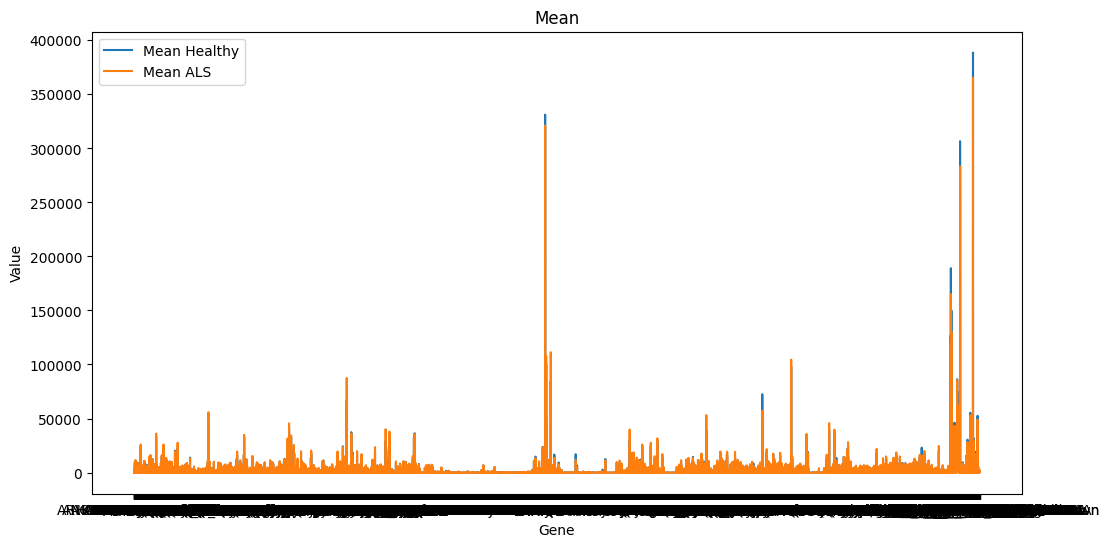

In [121]:
compare_two_groups(healthy, als_patients, "Mean Healthy", "Mean ALS")

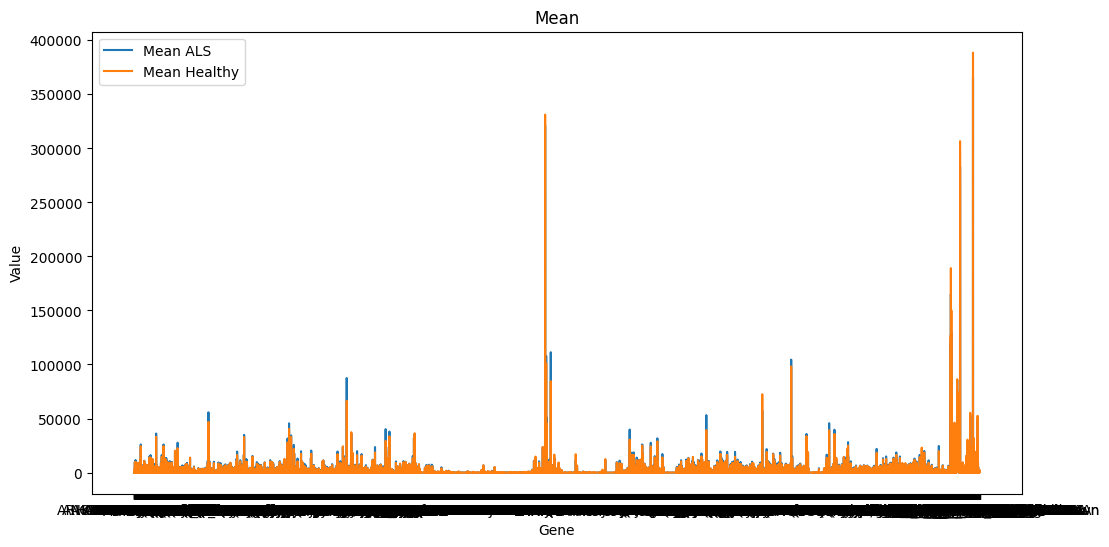

In [124]:
compare_two_groups(als_patients, healthy, "Mean ALS", "Mean Healthy")

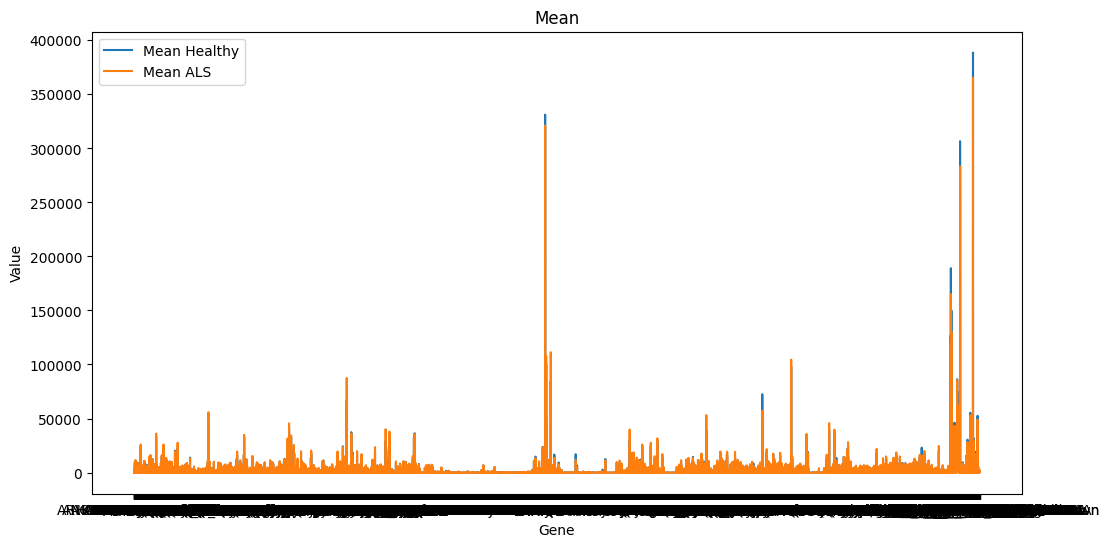

Top 100 genes where Mean Healthy is larger than Mean ALS :
 AluJb:Alu:SINE          24114.808925
L2a:L2:LINE             23486.050304
MIRb:MIR:SINE           23374.107505
AluSx:Alu:SINE          19713.770791
AluSx1:Alu:SINE         18132.374848
                            ...     
SST1:centr:Satellite     1086.689655
L1MB4:L1:LINE            1085.325761
MLT1K:ERVL-MaLR:LTR      1083.422718
L1MEc:L1:LINE            1076.267343
RNR1                     1073.108722
Length: 100, dtype: float64

Top 100 genes where Mean Healthy is smaller than Mean ALS :
 MBP        -26777.012982
GFAP       -21011.053955
PLP1       -13828.057201
HSP90AA1   -10827.988641
MTURN       -9249.152535
                ...     
PLEKHB1     -1631.081947
SYT11       -1624.244625
TAOK1       -1624.213793
APC         -1610.517647
ANLN        -1594.848682
Length: 100, dtype: float64


In [134]:
def compare_two_groups_top(group1, group2, label_1, label_2) -> None:
    '''
    This method plots the mean of each gene for two groups and shows the plot.
    '''
    mean_group1 = group1.drop(columns=['cns subregion', 'sample group']).mean()
    mean_group2 = group2.drop(columns=['cns subregion', 'sample group']).mean()

    mean_diff = mean_group1 - mean_group2

    top_10_greater = mean_diff.nlargest(100)
    top_10_smaller = mean_diff.nsmallest(100)

    plt.figure(figsize=(12, 6))
    plt.plot(mean_group1, label=label_1)
    plt.plot(mean_group2, label=label_2)
    plt.legend(loc='best')
    plt.title('Mean')
    plt.xlabel('Gene')
    plt.ylabel('Value')
    plt.show()

    print("Top 100 genes where", label_1, "is larger than", label_2, ":\n", top_10_greater)
    print("\nTop 100 genes where", label_1, "is smaller than", label_2, ":\n", top_10_smaller)

    return

compare_two_groups_top(healthy, als_patients, "Mean Healthy", "Mean ALS")

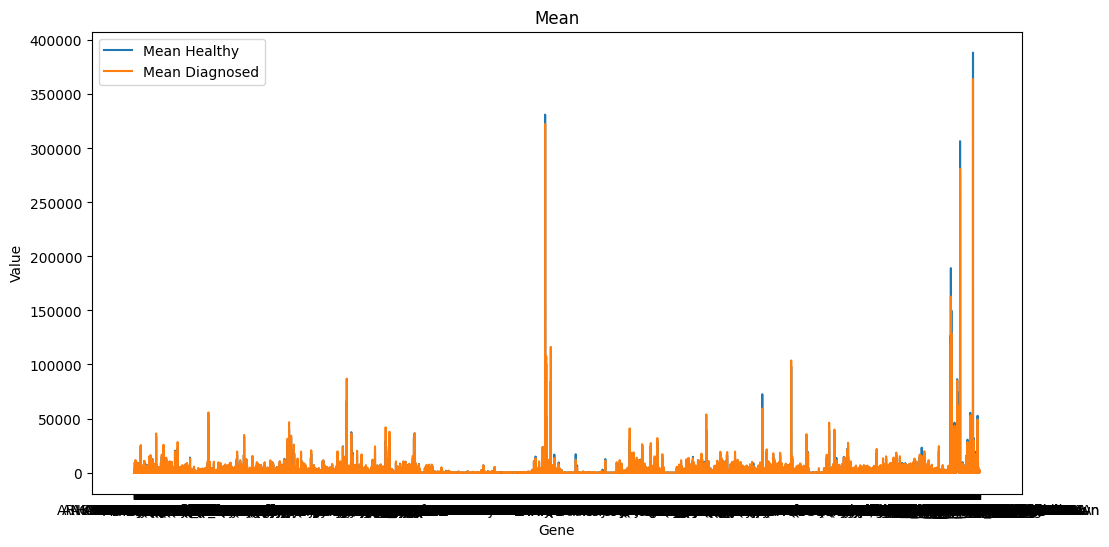

In [131]:
compare_two_groups(healthy, diagnosed, "Mean Healthy", "Mean Diagnosed")

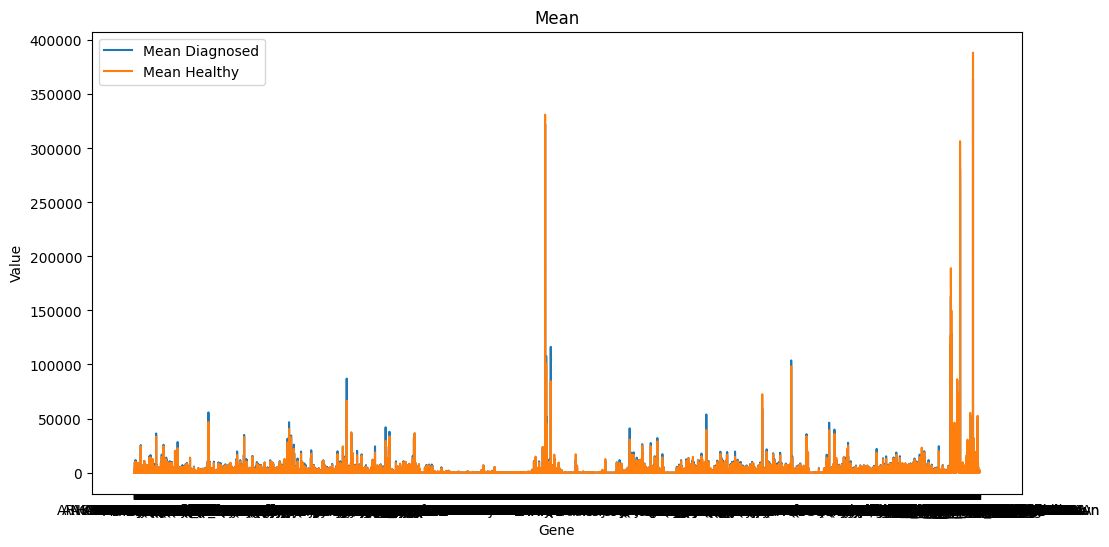

In [132]:
compare_two_groups(diagnosed, healthy, "Mean Diagnosed","Mean Healthy")

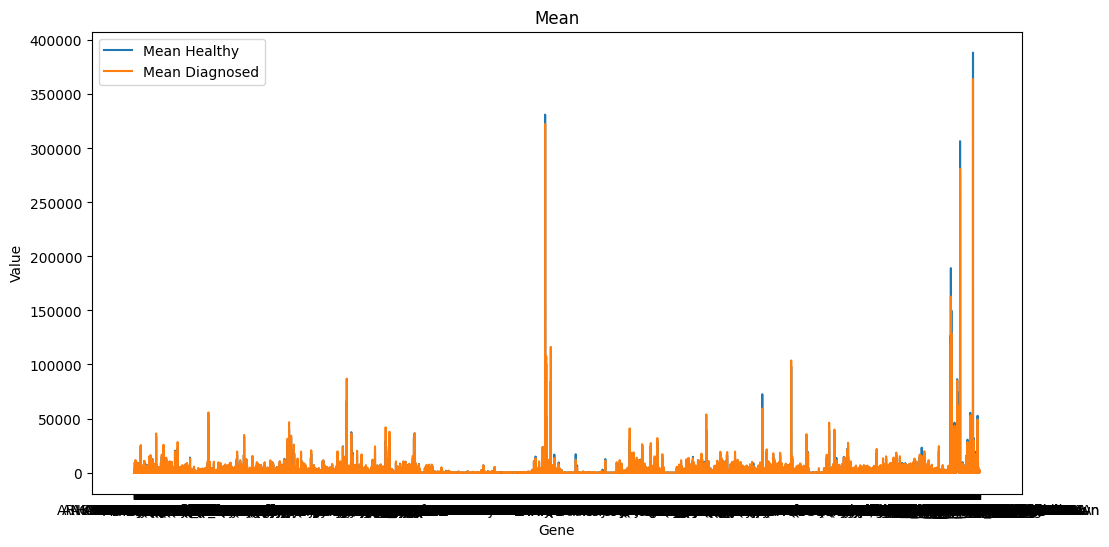

Top 10 genes where Mean Healthy is larger than Mean Diagnosed :
 AluJb:Alu:SINE     26343.569367
L2a:L2:LINE        25545.770625
MIRb:MIR:SINE      24458.440622
AluSx:Alu:SINE     21097.026267
AluSx1:Alu:SINE    19365.762486
L2c:L2:LINE        18350.843137
AluSz:Alu:SINE     18167.692934
MIR:MIR:SINE       15957.690344
AluJr:Alu:SINE     15517.585646
L2b:L2:LINE        15474.443581
dtype: float64

Top 10 genes where Mean Healthy is smaller than Mean Diagnosed :
 MBP        -31749.343322
GFAP       -20485.697373
PLP1       -14442.814650
HSP90AA1   -12534.259341
MTURN      -10383.618942
CALM1       -8754.520163
MAP1B       -7051.042175
SPARCL1     -6982.376989
AQP4        -6917.038846
MAP2        -6266.960044
dtype: float64


In [133]:
compare_two_groups_top(healthy, diagnosed, "Mean Healthy", "Mean Diagnosed")

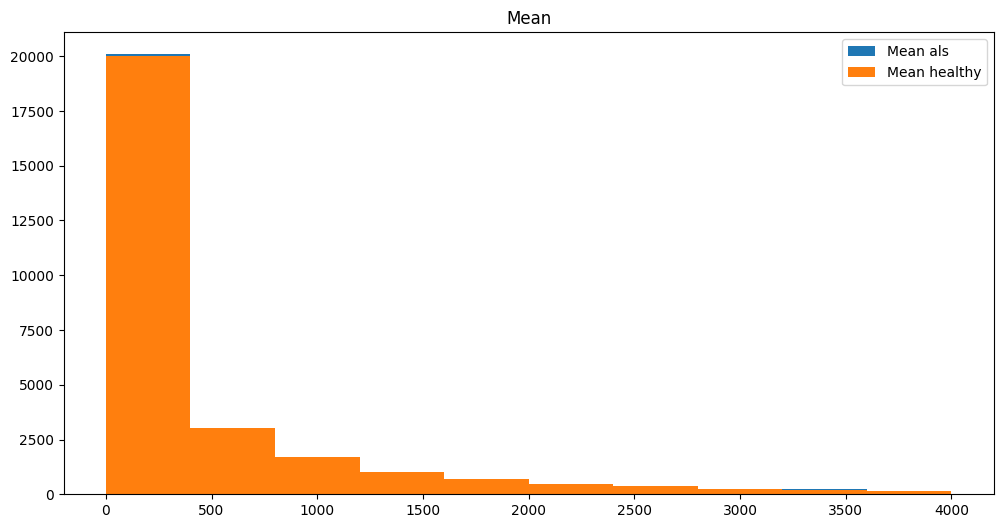

In [79]:
def compare_healthy_als_hist(healty_patients, als_patients) -> None:
    bins = 10
    mean_healthy = healty_patients.drop(columns=['cns subregion', 'sample group']).mean()
    mean_als = als_patients.drop(columns=['cns subregion', 'sample group']).mean()

    plt.figure(figsize=(12, 6))

    plt.hist(mean_als, bins=bins, label='Mean als', range=(0, 4000))
    plt.hist(mean_healthy, bins= bins, label='Mean healthy', range=(0, 4000))

    plt.legend(loc='best')
    plt.title('Mean')

    plt.show()
    return

compare_healthy_als_hist(healthy, als_patients )

In [ ]:
samples_df = samples.get_samples()

annotations_df = annotations.get_annotations()
samples_df = samples_df.loc[annotations_df.index]

inference = DefaultInference(n_cpus=8)
dds = DeseqDataSet(
    counts=samples_df,
    metadata=annotations_df,
    design_factors=["sample group"], 
    refit_cooks=True,
    inference=inference,
)

dds.deseq2()

stat_res = DeseqStats(dds, inference=inference)
stat_res.summary()

stat_res.lfc_shrink()


In [78]:
print(dds.varm["LFC"])

                        intercept  \
A1BG                     3.576729   
A1BG-AS1                 4.735475   
A1CF                    -1.303420   
A2M                      7.767150   
A2M-AS1                  4.605819   
...                           ...   
X8_LINE:CR1:LINE         6.124006   
X9_LINE:L1:LINE          4.700183   
Zaphod2:hAT-Tip100:DNA   6.019868   
Zaphod3:hAT-Tip100:DNA   7.335889   
Zaphod:hAT-Tip100:DNA    7.443053   

                        sample group_Non-Neurological Control_vs_ALS Spectrum MND  \
A1BG                                                             0.012566           
A1BG-AS1                                                         0.036706           
A1CF                                                            -0.409046           
A2M                                                              0.082556           
A2M-AS1                                                         -0.129250           
...                                          

In [79]:
stat_res.results_df.to_csv("differential_expression_results.csv")

In [80]:
expression_results = pd.read_csv("differential_expression_results.csv")

In [82]:
expression_results

,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,A1BG,35.993900,0.006783,0.086610,0.127165,0.898810,0.955985
1,A1BG-AS1,113.742744,0.029841,0.075133,0.532623,0.594294,0.779338
2,A1CF,0.155759,-0.006216,0.109801,-0.341353,0.732838,NaN
3,A2M,2345.384500,0.045321,0.097158,0.746589,0.455311,0.677644
4,A2M-AS1,99.268400,-0.125481,0.094082,-1.911716,0.055913,0.205105
...,...,...,...,...,...,...,...
28948,X8_LINE:CR1:LINE,458.854980,0.031340,0.076980,0.565669,0.571619,0.764162
28949,X9_LINE:L1:LINE,109.576020,-0.037168,0.081511,-0.665525,0.505715,0.716352
28950,Zaphod2:hAT-Tip100:DNA,411.010280,0.032202,0.077982,0.616807,0.537362,0.740167
28951,Zaphod3:hAT-Tip100:DNA,1539.491100,0.076922,0.088156,1.000003,0.317309,0.559271


In [83]:
expression_results.index.name = None
expression_results.rename(columns={'Unnamed: 0': 'gene'}, inplace=True)

In [107]:
expression_results.to_csv("differential_expression_results.csv", index=False)

In [158]:
significant_genes = expression_results[expression_results['padj'] < 0.05]

significant_genes = significant_genes.reindex(significant_genes['log2FoldChange'].abs().sort_values(ascending=False).index)

top_100_genes = significant_genes.head(100)

In [159]:
top_100_genes

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
22035,SELE,12.086734,3.600976,0.458631,3.263075,1.102103e-03,0.022710
7063,GABRE,32.960600,3.389264,0.295861,4.312664,1.612994e-05,0.002728
2938,CCL8,1.094456,2.869604,0.553125,5.531628,3.172722e-08,0.000134
4209,CSF3,5.875627,2.602067,0.563383,4.953869,7.275234e-07,0.000514
23825,SPATA31A7,0.589098,2.108294,0.594700,4.140513,3.465304e-05,0.003891
...,...,...,...,...,...,...,...
24198,STC1,36.684105,1.030741,0.435601,3.247830,1.162887e-03,0.023149
12601,LOC101928160,1.089137,1.025127,0.498450,3.266251,1.089817e-03,0.022554
28266,L1PA4:L1:LINE,48727.090000,1.024986,0.154780,3.102665,1.917866e-03,0.029837
8831,IGFALS,8.747171,1.022692,0.231803,5.018949,5.195498e-07,0.000433


In [157]:
expression_results

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
796,ANKRD20A9P,12.357415,1.948242,0.268031,7.534761,4.892313e-14,1.175476e-09
14172,MAPK8IP1P2,45.719130,-0.049603,0.126997,-6.680468,2.381803e-11,2.861379e-07
27397,ZNF251,330.458500,0.413397,0.076149,5.872133,4.302222e-09,3.445650e-05
6811,FNIP2,2325.370000,-0.341616,0.061148,-5.584164,2.348265e-08,1.335704e-04
2938,CCL8,1.094456,2.869604,0.553125,5.531628,3.172722e-08,1.335704e-04
...,...,...,...,...,...,...,...
27778,ZNF733P,0.000000,NaN,NaN,NaN,NaN,NaN
27937,ZSCAN5C,0.000000,NaN,NaN,NaN,NaN,NaN
28050,CheshMITE:hAT-Charlie:DNA,0.000000,NaN,NaN,NaN,NaN,NaN
28093,HAL1N1_MD:L1:LINE,0.000000,NaN,NaN,NaN,NaN,NaN


In [134]:
expression_results.set_index('gene', inplace=True)
expression_results

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene,,,,,,
ANKRD20A9P,12.357415,1.948242,0.268031,7.534761,4.892313e-14,1.175476e-09
MAPK8IP1P2,45.719130,-0.049603,0.126997,-6.680468,2.381803e-11,2.861379e-07
ZNF251,330.458500,0.413397,0.076149,5.872133,4.302222e-09,3.445650e-05
TBX3,58.858875,1.307446,0.256527,5.522847,3.335507e-08,1.335704e-04
CCL8,1.094456,2.869604,0.553125,5.531628,3.172722e-08,1.335704e-04
...,...,...,...,...,...,...
HSAT6:Satellite:Satellite,0.054977,0.001814,0.110064,0.068883,9.450828e-01,NaN
MLT1E-int:ERVL-MaLR:LTR,0.351450,0.009397,0.108681,0.432450,6.654142e-01,NaN
MLT1M-int:ERVL-MaLR:LTR,0.032701,-0.000682,0.127811,-0.022692,9.818959e-01,NaN


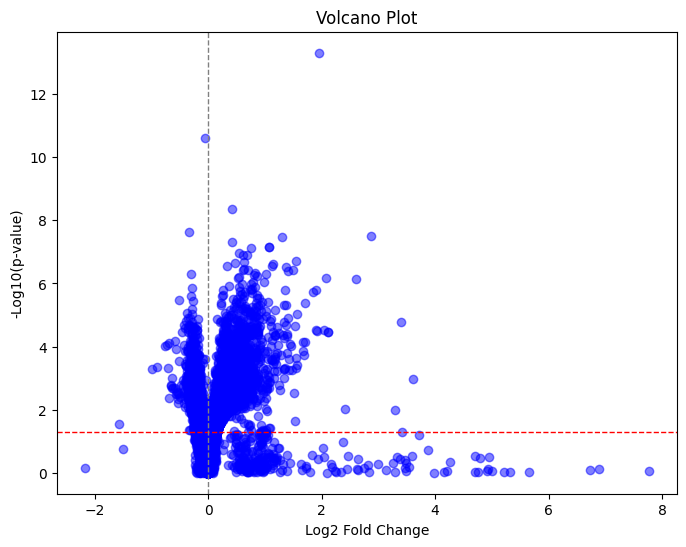

In [127]:
# Volcano plot
plt.figure(figsize=(8, 6))
plt.scatter(expression_results['log2FoldChange'], -np.log10(expression_results['pvalue']), color='blue', alpha=0.5)
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10(p-value)')
plt.title('Volcano Plot')
plt.axhline(-np.log10(0.05), color='red', linestyle='--', linewidth=1)
plt.axvline(0, color='gray', linestyle='--', linewidth=1)
plt.show()

## Step 6 - Multivariate Analysis

In [190]:
# Filter annotations to exclude "Other Neurological Disorders" and merge with sample data on indices.

elastic_df = annotations.get_annotations()[annotations.get_annotations()["sample group"] != "Other Neurological Disorders"]
elastic_df = elastic_df.merge(samples.get_samples(), left_index=True, right_index=True)
elastic_df 

,cns subregion,sample group,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,...,X6B_LINE:CR1:LINE,X7A_LINE:CR1:LINE,X7B_LINE:CR1:LINE,X7C_LINE:CR1:LINE,X7D_LINE:CR1:LINE,X8_LINE:CR1:LINE,X9_LINE:L1:LINE,Zaphod2:hAT-Tip100:DNA,Zaphod3:hAT-Tip100:DNA,Zaphod:hAT-Tip100:DNA
GSM3533230,Frontal Cortex,ALS Spectrum MND,42,149,0,3327,101,78,4,0,...,986,2218,2096,1120,84,556,134,570,2045,2446
GSM3533231,Frontal Cortex,ALS Spectrum MND,25,107,2,1787,153,109,2,1,...,1216,2373,2001,1144,118,582,153,552,2057,2279
GSM3533232,Frontal Cortex,ALS Spectrum MND,20,95,0,1830,121,127,1,1,...,905,2018,1815,1011,84,571,126,479,1659,1778
GSM3533233,Frontal Cortex,ALS Spectrum MND,22,101,0,2131,142,143,5,1,...,935,2278,2032,1198,97,562,132,540,2032,2135
GSM3533234,Frontal Cortex,ALS Spectrum MND,22,102,0,1706,83,178,1,3,...,966,2295,1993,1152,96,582,124,539,1742,1939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM3533401,Frontal Cortex,ALS Spectrum MND,23,113,0,2130,72,71,2,3,...,553,1243,1089,658,72,320,73,311,1102,1169
GSM3533402,Frontal Cortex,ALS Spectrum MND,134,300,0,6077,171,42,8,5,...,719,1988,1691,966,119,460,109,399,1619,1724
GSM3533403,Frontal Cortex,ALS Spectrum MND,64,290,0,4752,118,174,8,2,...,623,1466,1246,726,61,358,107,347,1284,1469
GSM3533404,Frontal Cortex,ALS Spectrum MND,124,332,0,3516,141,173,3,2,...,743,1846,1680,936,110,479,120,503,1646,1839


In [191]:
# Normalizing the data.

sample_group = elastic_df['sample group']
elastic_df.drop(columns=['sample group', 'cns subregion'], inplace=True)

scaler = StandardScaler()
normalized = pd.DataFrame(scaler.fit_transform(elastic_df), columns=elastic_df.columns)

In [192]:
normalized

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,X6B_LINE:CR1:LINE,X7A_LINE:CR1:LINE,X7B_LINE:CR1:LINE,X7C_LINE:CR1:LINE,X7D_LINE:CR1:LINE,X8_LINE:CR1:LINE,X9_LINE:L1:LINE,Zaphod2:hAT-Tip100:DNA,Zaphod3:hAT-Tip100:DNA,Zaphod:hAT-Tip100:DNA
0,0.197168,0.592234,-0.261686,0.636852,-0.037928,-0.852487,0.558088,-1.056732,0.556794,-0.641223,...,0.763176,0.896824,1.036541,0.903570,-0.229917,0.712706,0.687299,1.209981,1.022973,1.409615
1,-0.625561,-0.257526,2.661982,-0.548825,1.427707,-0.296127,-0.263823,-0.649135,-0.594354,-0.641223,...,1.754874,1.213457,0.818532,1.003150,1.004375,0.912342,1.257209,1.065290,1.048585,1.072780
2,-0.867540,-0.500314,-0.261686,-0.515718,0.525778,0.026921,-0.674779,-0.649135,-0.978070,-0.641223,...,0.413926,0.488265,0.391694,0.451311,-0.229917,0.827880,0.447337,0.478485,0.199114,0.062277
3,-0.770748,-0.378920,-0.261686,-0.283972,1.117669,0.314074,0.969044,-0.649135,-0.292863,-0.641223,...,0.543278,1.019392,0.889672,1.227205,0.242018,0.758776,0.627308,0.968829,0.995227,0.782336
4,-0.770748,-0.358688,-0.261686,-0.611188,-0.545264,0.942222,-0.674779,0.166058,-0.429904,-0.641223,...,0.676941,1.054119,0.800174,1.036343,0.205715,0.912342,0.387346,0.960790,0.376265,0.387010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,-0.722352,-0.136131,-0.261686,-0.284742,-0.855302,-0.978116,-0.263823,0.166058,-0.703987,-0.641223,...,-1.103803,-1.094899,-1.274354,-1.013344,-0.665550,-1.099370,-1.142412,-0.871971,-0.989720,-1.166059
158,4.649582,3.647324,-0.261686,2.754132,1.935043,-1.498582,2.201911,0.981251,4.887303,-0.641223,...,-0.388056,0.426982,0.107135,0.264599,1.040678,-0.024409,-0.062583,-0.164589,0.113740,-0.046639
159,1.261876,3.445000,-0.261686,1.733988,0.441222,0.870434,2.201911,-0.241539,2.420557,-0.641223,...,-0.801982,-0.639356,-0.914065,-0.731201,-1.064880,-0.807595,-0.122573,-0.582587,-0.601268,-0.560967
160,4.165624,4.294760,-0.261686,0.782367,1.089484,0.852487,0.147132,-0.241539,3.982830,-0.641223,...,-0.284574,0.136905,0.081891,0.140124,0.713953,0.121478,0.267365,0.671407,0.171367,0.185312


In [247]:
sample_group

GSM3533230    ALS Spectrum MND
GSM3533231    ALS Spectrum MND
GSM3533232    ALS Spectrum MND
GSM3533233    ALS Spectrum MND
GSM3533234    ALS Spectrum MND
                    ...       
GSM3533401    ALS Spectrum MND
GSM3533402    ALS Spectrum MND
GSM3533403    ALS Spectrum MND
GSM3533404    ALS Spectrum MND
GSM3533405    ALS Spectrum MND
Name: sample group, Length: 162, dtype: object

In [195]:
sample_group_series = sample_group.reset_index(drop=True)
sample_group_series

0      ALS Spectrum MND
1      ALS Spectrum MND
2      ALS Spectrum MND
3      ALS Spectrum MND
4      ALS Spectrum MND
             ...       
157    ALS Spectrum MND
158    ALS Spectrum MND
159    ALS Spectrum MND
160    ALS Spectrum MND
161    ALS Spectrum MND
Name: sample group, Length: 162, dtype: object

In [196]:
combined_df = pd.concat([normalized, sample_group_series], axis=1)


In [198]:
X = combined_df.drop(columns=['sample group'])
y = combined_df['sample group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

elasticNet = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, C=0.5)
elasticNet.fit(X_train, y_train)

y_pred = elasticNet.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.30303030303030304


/Users/alexeybrown/anaconda3/envs/bio/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


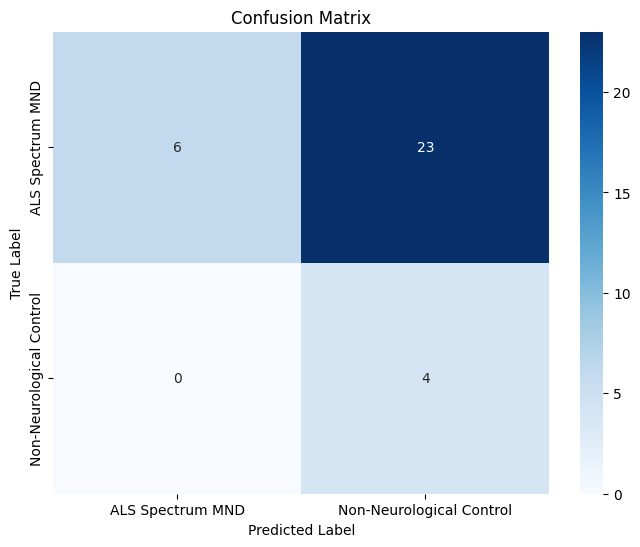

In [199]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=elasticNet.classes_, yticklabels=elasticNet.classes_)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

plt.show()

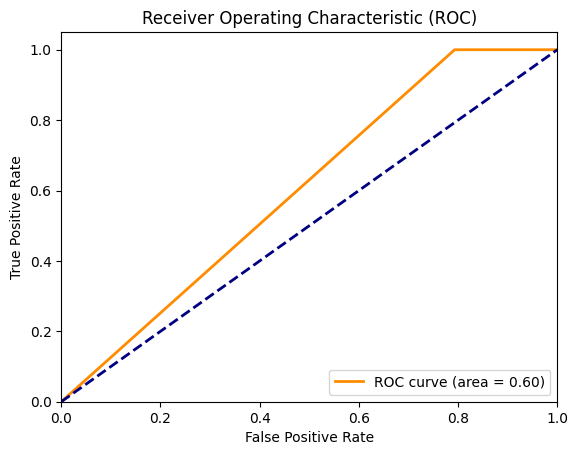

In [202]:
label_encoder = LabelEncoder()
y_true_binary = label_encoder.fit_transform(y_test)
y_pred_binary = label_encoder.transform(y_pred)

fpr, tpr, _ = roc_curve(y_true_binary, y_pred_binary)
roc_auc = auc(fpr, tpr)

plt.figure()

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")

plt.show()


In [207]:
x = combined_df.drop(columns=['sample group'])
y = combined_df['sample group']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

elasticNet = LogisticRegressionCV(penalty='elasticnet', cv= 3, solver='saga', l1_ratios=[0.25,0.5,0.75], Cs=[0.1,0.5], scoring= 'accuracy')
elasticNet.fit(X_train, y_train)

y_pred = elasticNet.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


/Users/alexeybrown/anaconda3/envs/bio/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/alexeybrown/anaconda3/envs/bio/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/alexeybrown/anaconda3/envs/bio/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/alexeybrown/anaconda3/envs/bio/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/alexeybrown/anaconda3/envs/bio/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

Accuracy: 0.6363636363636364


/Users/alexeybrown/anaconda3/envs/bio/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [208]:
y_pred = elasticNet.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6363636363636364


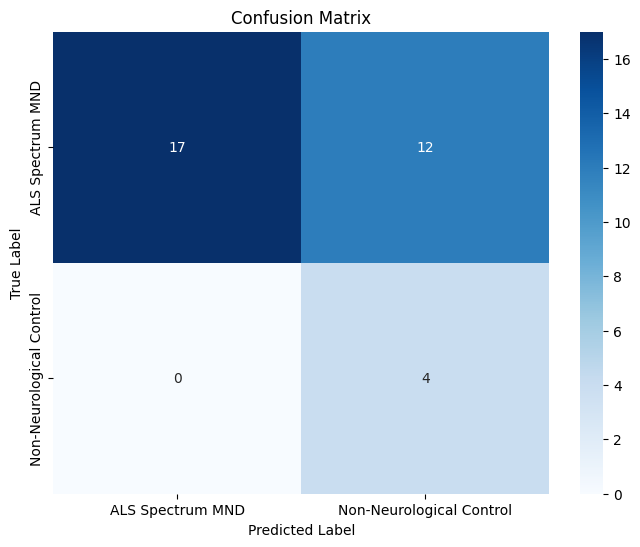

In [210]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=elasticNet.classes_, yticklabels=elasticNet.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [211]:
accuracy = accuracy_score(y_test, y_pred)

precision = precision_score(y_test, y_pred, average='weighted')

recall = recall_score(y_test, y_pred, average='weighted')

f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.6363636363636364
Precision: 0.9090909090909091
Recall: 0.6363636363636364
F1 Score: 0.6980237154150198


In [213]:
elasticNet.coef_

array([[0., 0., 0., ..., 0., 0., 0.]])

In [215]:
top_100_indices = np.argsort(np.abs(elasticNet.coef_))[0][-100:]

index_coef_dict = {index: coef for index, coef in zip(top_100_indices, elasticNet.coef_[0][top_100_indices])}

index_coef_dict

{9346: 0.0026508820482450037,
 9830: 0.0026521079886601333,
 5772: 0.0026585402262169922,
 2921: 0.00265858000482906,
 10844: -0.002718785488255671,
 25468: 0.0027294223229039245,
 14934: 0.0027779680798589402,
 8059: 0.002790103267455989,
 3426: 0.002866488913056058,
 20527: 0.002885246440066285,
 22266: 0.0029202984098251985,
 4610: 0.0029454241952149916,
 19431: 0.0030452956948608884,
 10659: 0.0030605698552479744,
 21125: 0.003061734219518175,
 18664: 0.0030648135669591333,
 15443: 0.0030672672842459014,
 11470: 0.0030941380763036216,
 10729: 0.0031053523589898054,
 11009: 0.0031829373140454757,
 8914: 0.0031909021268909064,
 448: -0.003203981852642114,
 12637: 0.0032241371640108073,
 10165: 0.003266904664677001,
 4535: 0.003326595308959062,
 20224: 0.0033383078754292534,
 20225: 0.0033383078754292534,
 15272: 0.0033394773873571993,
 23823: 0.0033467310130644327,
 23825: 0.0033467310130644327,
 5868: 0.0033594726915806964,
 18849: 0.003413534940150667,
 20140: 0.003509222930521484,

In [218]:
param_grid = {
    'penalty': ['elasticnet', 'l2', 'l1'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'l1_ratio': [0.25, 0.5, 0.75],
    'C': [0.1, 0.5, 1.0],
    'max_iter': [100, 200, 300]
}

grid_search = GridSearchCV(estimator=LogisticRegression(), param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


/Users/alexeybrown/anaconda3/envs/bio/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/alexeybrown/anaconda3/envs/bio/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/alexeybrown/anaconda3/envs/bio/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/alexeybrown/anaconda3/envs/bio/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/alexeybrown/anaconda3/envs/bio/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is

Best Hyperparameters: {'C': 1.0, 'l1_ratio': 0.25, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
Accuracy: 0.9090909090909091


In [234]:
grid_results = grid_search.cv_results_

params = grid_results['params']
mean_scores = grid_results['mean_test_score']

for param, score in zip(params, mean_scores):
    print("Parameters:", param)
    print("Mean Score:", score)

Parameters: {'C': 0.1, 'l1_ratio': 0.25, 'max_iter': 100, 'penalty': 'elasticnet', 'solver': 'newton-cg'}
Mean Score: nan
Parameters: {'C': 0.1, 'l1_ratio': 0.25, 'max_iter': 100, 'penalty': 'elasticnet', 'solver': 'lbfgs'}
Mean Score: nan
Parameters: {'C': 0.1, 'l1_ratio': 0.25, 'max_iter': 100, 'penalty': 'elasticnet', 'solver': 'liblinear'}
Mean Score: nan
Parameters: {'C': 0.1, 'l1_ratio': 0.25, 'max_iter': 100, 'penalty': 'elasticnet', 'solver': 'sag'}
Mean Score: nan
Parameters: {'C': 0.1, 'l1_ratio': 0.25, 'max_iter': 100, 'penalty': 'elasticnet', 'solver': 'saga'}
Mean Score: 0.3255813953488372
Parameters: {'C': 0.1, 'l1_ratio': 0.25, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
Mean Score: 0.8992248062015503
Parameters: {'C': 0.1, 'l1_ratio': 0.25, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Mean Score: 0.8992248062015503
Parameters: {'C': 0.1, 'l1_ratio': 0.25, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Mean Score: 0.3023255813953488
Paramet

In [235]:
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))

                          precision    recall  f1-score   support

        ALS Spectrum MND       0.91      1.00      0.95        29
Non-Neurological Control       1.00      0.25      0.40         4

                accuracy                           0.91        33
               macro avg       0.95      0.62      0.68        33
            weighted avg       0.92      0.91      0.88        33



In [250]:
feature_names = X_train.columns

coef_df = pd.DataFrame({'Gene': feature_names, 'Coefficient': best_model.coef_[0]})

print(coef_df)
coef_df.to_csv("gene_coefficients.csv")

                         Gene  Coefficient
0                        A1BG     0.000078
1                    A1BG-AS1    -0.000756
2                        A1CF    -0.001815
3                         A2M     0.000578
4                     A2M-AS1    -0.003934
...                       ...          ...
28948        X8_LINE:CR1:LINE     0.000412
28949         X9_LINE:L1:LINE    -0.000038
28950  Zaphod2:hAT-Tip100:DNA    -0.001401
28951  Zaphod3:hAT-Tip100:DNA     0.000054
28952   Zaphod:hAT-Tip100:DNA     0.000618

[28953 rows x 2 columns]


In [257]:
coef_df_sorted = coef_df.reindex(coef_df['Coefficient'].sort_values(key=abs, ascending=False).index)

# Select the top 100 coefficients
top_100_coef = coef_df_sorted.head(100)


In [261]:
top_100_coef

,Gene,Coefficient
15308,MIR4284,0.024580
15443,MIR4484,0.020950
24401,SYCN,0.019257
12239,LOC100506358,0.018356
18330,OR4D1,0.018082
...,...,...
13434,LOC339975,0.011207
25498,TNFSF11,0.011198
21003,RERGL,0.011162
18148,OR10D3,0.011158


In [262]:
coef_df_sorted = coef_df.sort_values(by='Coefficient')

top_negative = coef_df_sorted.head(10)
print(top_negative)

            Gene  Coefficient
2194    C1orf189    -0.012577
785       ANKRD2    -0.010897
18192     OR13C4    -0.010575
16250    MIR6813    -0.010519
2699      CAVIN2    -0.010108
3083       CD79B    -0.010091
14962    MIR3121    -0.009588
10773  LINC01121    -0.009508
241    ACTN1-AS1    -0.009500
11175  LINC01655    -0.009471


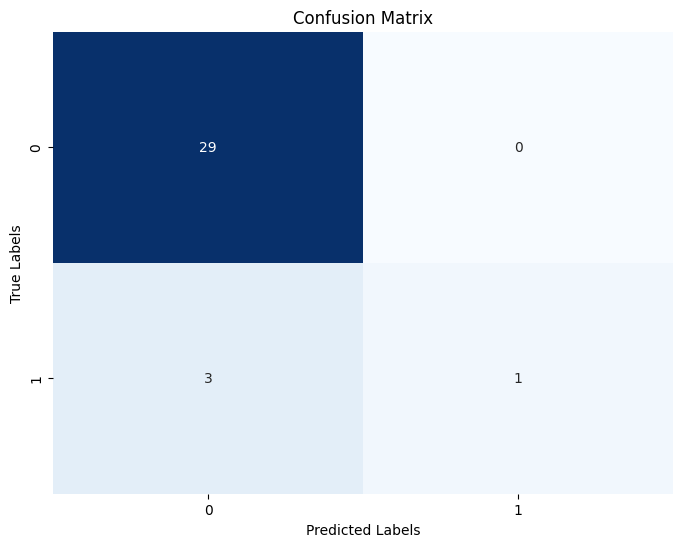

In [236]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

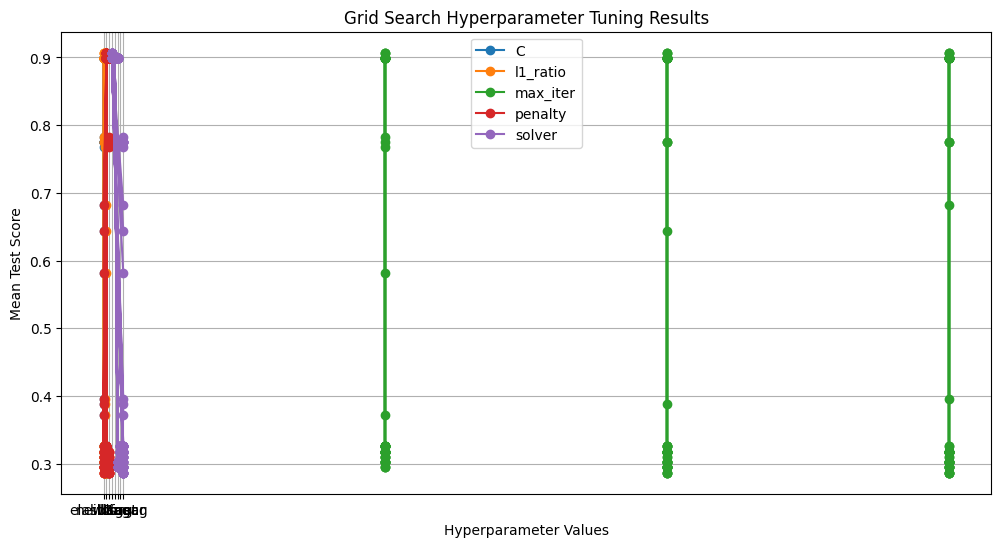

In [237]:
params = grid_results['params']
mean_scores = grid_results['mean_test_score']

hyperparameters = list(params[0].keys())
hyperparams_values = {param: [combination[param] for combination in params] for param in hyperparameters}

plt.figure(figsize=(12, 6))

for param, values in hyperparams_values.items():
    plt.plot(values, mean_scores, marker='o', label=param)

plt.xlabel('Hyperparameter Values')
plt.ylabel('Mean Test Score')
plt.title('Grid Search Hyperparameter Tuning Results')
plt.legend()
plt.grid(True)
plt.show()
